In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

plt.rcParams['font.sans-serif'] = ['SimHei']

### 1. Read Data

In [2]:
# Merge data files
data_list = []
for i in range(1, 9):
    path = f"data\\bj_danke_{i}.csv"
    df = pd.read_csv(path)
    data_list.append(df)
data = pd.concat(data_list)

data.head()

,价格,面积,编号,户型,楼层,位置1,位置2,小区,地铁
0,1330.0,9.0,38738-A,3室1卫,9/11层,房山区,良乡大学城西,紫汇家园,地铁：距房山线良乡大学城西站550米
1,5810.0,39.0,64752-A,1室1卫,9/12层,东城区,广渠门内,绿景苑,地铁：距7号线广渠门内站650米
2,4820.0,36.0,65359-A,1室1卫,1/6层,东城区,景泰,定安里,地铁：距14号线东段景泰站450米
3,1850.0,9.0,185-B,4室2卫,2/27层,朝阳区,管庄,京通苑阳光华苑,地铁：距八通线管庄站500米
4,9000.0,116.0,17830-A,2室1卫,8/16层,朝阳区,十里堡,天天朝阳,地铁：距6号线十里堡站850米


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7697 entries, 0 to 848
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   价格      6602 non-null   object
 1   面积      6602 non-null   object
 2   编号      6602 non-null   object
 3   户型      6602 non-null   object
 4   楼层      6602 non-null   object
 5   位置1     6602 non-null   object
 6   位置2     6602 non-null   object
 7   小区      6602 non-null   object
 8   地铁      6602 non-null   object
dtypes: object(9)
memory usage: 601.3+ KB


### 2. Data cleaning

In [4]:
# Data deduplication: Deletes duplicate values
# print(data[data.duplicated()])
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [5]:
# Missing values processing: delete the row where the missing value is located and reset the index
# print(data.isnull().sum())
data.dropna(axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

In [6]:
# Outlier cleaning
data["户型"].unique()
print(data[data["户型"] == "户型"])
data = data[data["户型"] != "户型"]

      价格  面积  编号  户型  楼层  位置1  位置2  小区  地铁
1377  价格  面积  编号  户型  楼层  位置1  位置2  小区  地铁


In [7]:
# Data cleaning: Column replacement
data.loc[:, "地铁"] = data["地铁"].apply(lambda x: x.replace("地铁：", ""))

In [8]:
# Add columns
data.loc[:, "所在楼层"] = data["楼层"].apply(lambda x: int(x.split("/")[0]))
data.loc[:, "总楼层"] = data["楼层"].apply(lambda x: int(x.replace("层", "").split("/")[-1]))
data.loc[:, "地铁数"] = data["地铁"].apply(lambda x: len(re.findall("线", x)))
data.loc[:, "距离地铁距离"] = data["地铁"].apply(lambda x: int(re.findall("(\d+)米", x)[-1])
                                         if re.findall("(\d+)米", x) else -1)

In [9]:
# Data type conversion
data["价格"] = data["价格"].astype(np.int64)
data["面积"] = data["面积"].astype(np.int64)
data["距离地铁距离"] = data["距离地铁距离"].astype(np.int64)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6024 entries, 0 to 6024
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   价格      6024 non-null   int64 
 1   面积      6024 non-null   int64 
 2   编号      6024 non-null   object
 3   户型      6024 non-null   object
 4   楼层      6024 non-null   object
 5   位置1     6024 non-null   object
 6   位置2     6024 non-null   object
 7   小区      6024 non-null   object
 8   地铁      6024 non-null   object
 9   所在楼层    6024 non-null   int64 
 10  总楼层     6024 non-null   int64 
 11  地铁数     6024 non-null   int64 
 12  距离地铁距离  6024 non-null   int64 
dtypes: int64(6), object(7)
memory usage: 658.9+ KB


In [11]:
data.to_csv("data/rent.csv", encoding="utf_8_sig")

### 3. Data analysis visulization

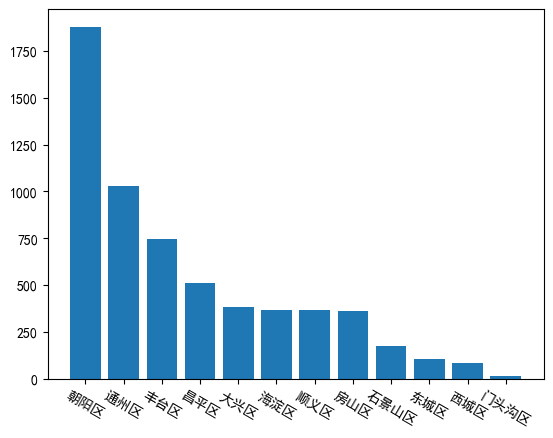

In [12]:
# Regional analysis
regions = data.groupby("位置1").size().sort_values(ascending=False)
region_list = regions.values.tolist()
region_size = np.arange(len(region_list))
region_label = regions.index.tolist()
plt.bar(region_size, height=region_list)
plt.xticks(region_size, region_label, rotation=-30)
plt.show()

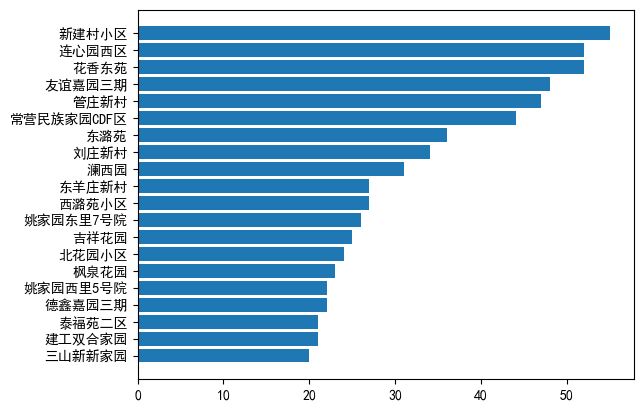

In [13]:
# Cell analysis
cells = data.groupby("小区").size().sort_values(ascending=False)[:20].sort_values(ascending=True)
cell_list = cells.values.tolist()
cell_size = np.arange(len(cell_list))
cell_label = cells.index.tolist()
plt.barh(cell_size, width=cell_list)
plt.yticks(cell_size, cell_label)
plt.show()

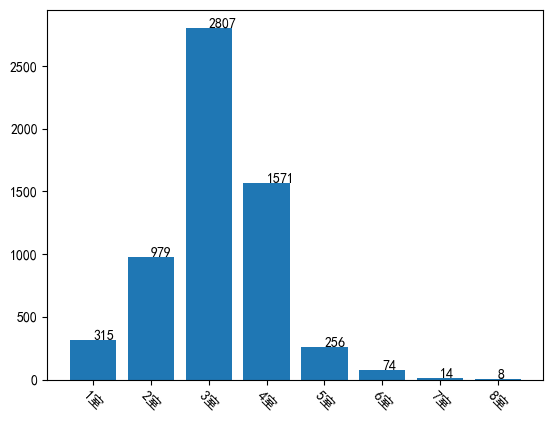

In [16]:
# Apartment type analysis
def type_count(x):
    result = dict()
    for k, v in x.items():
        idx = k.index("室")
        if result.get(k[0:idx+1]):
            result[k[0:idx+1]] += v
        else:
            result[k[0:idx+1]] = v
    return result

def add_value_label(x_list, y_list):
    for i in range(0, len(x_list)):
        plt.annotate(y_list[i], (i, y_list[i]))
        
apt_types = type_count(data.groupby("户型").size())
type_label = apt_types.keys()
type_list = apt_types.values() 
type_size = np.arange(len(type_list))
plt.bar(type_size, height=type_list)
add_value_label(list(type_label), list(type_list))
plt.xticks(type_size, type_label, rotation=-45)
plt.show()

Text(0.5, 1.0, 'Area price')

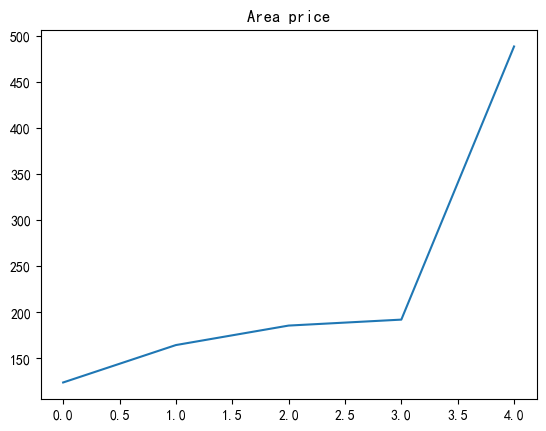

In [44]:
# Traffic analysis
area_price = data.groupby(["地铁数"])["价格"].sum() / data.groupby(["地铁数"])["面积"].sum()

plt.plot(list(area_price.index), list(area_price.values))
plt.title("Area price")